In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import sys
import os
%load_ext tensorboard

#sys.path.append(os.path.abspath("e:/python/CNN-TensorFlow/Brain-Segmentation-master/"))
os.chdir("e:/python/CNN-TensorFlow/Brain-Segmentation-master/")
from test_bran_segmentation import *
#dir()

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
model = load_model("weights/label"+str(7)+"/best.h5",custom_objects={'dice_coefficient': dice_coefficient, 'dice_loss':  dice_loss})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
test_stuff = predict("E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\T1.nii", "E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\T2_FLAIR.nii", "E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\T1_IR.nii", 7)

Instructions for updating:
Use tf.gfile.GFile.


In [4]:
import dicom2nifti
import dicom2nifti.settings as settings
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import nibabel as nib

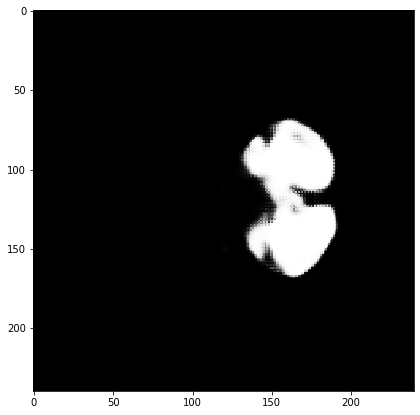

In [5]:
affine = [[-0.95833302, 0., 0., 110.89199829], [0., -0.91877592, -0.85302001, 115.17299652], [0., -0.27249241, 2.87616897, -15.59920025], [0., 0., 0., 1.]]
nifti_img = nib.Nifti1Image(test_stuff, affine)
plt.figure(figsize = (7,7))
plt.imshow(nifti_img.get_fdata()[:,:,10], cmap='gray', aspect='equal', resample=False)

In [6]:
bg = nib.load("E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\T1.nii")
orig = nib.load("E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\LabelsForTraining.nii")
orig_test = nib.load("E:\\python\\phd\\datasets\\mrbrains_full_2013\\TrainingData\\1\\LabelsForTesting.nii")

C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


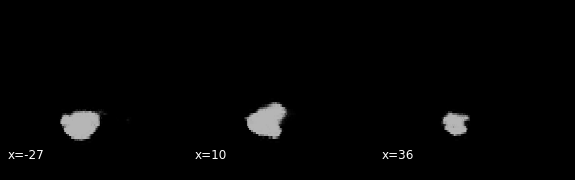

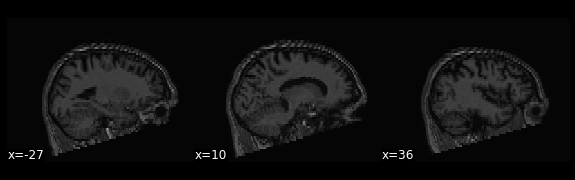

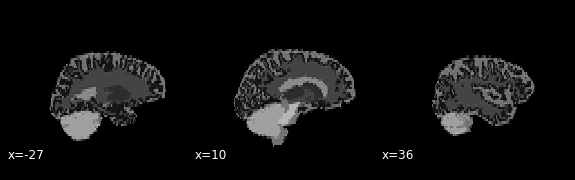

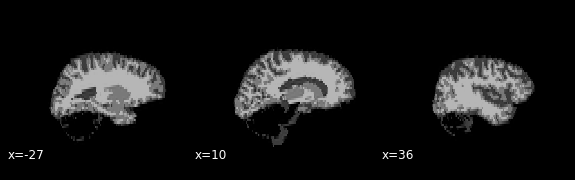

In [7]:
plot_anat(nifti_img, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10])
plot_anat(bg, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10])
plot_anat(orig, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10])
plot_anat(orig_test, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10])

In [8]:
import keras.backend as K
K.clear_session()
tf.compat.v1.reset_default_graph()

In [9]:
print(tf.executing_eagerly())
    

print(tf.__version__)
import numpy as np
m = tf.keras.metrics.MeanIoU(num_classes=2)

pred_ = np.array(nifti_img.get_data() > 0.5).astype(np.uint8)
true_ = np.array(orig.get_data() == 7).astype(np.uint8)


#m.reset_states()

m.update_state(pred_, true_)
#with tf.compat.v1.Session() as sess: 
print(m.result())



# my_eval(nifti_img, orig)

False
2.0.0
Tensor("Identity:0", shape=(), dtype=float32)


C:\Users\StarDust\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
C:\Users\StarDust\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':


In [62]:


def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [113]:
def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

print(IoU(pred_, true_))

Tensor("Mean_3:0", shape=(), dtype=float32)


In [114]:
print(orig.shape)


(240, 240, 48)


In [19]:
_int = 0
_uni = 0
for i in range(len(pred_)):
    for j in range(len(pred_[i])):
        for k in range(len(pred_[i][j])):
            if pred_[i][j][k]> 0 and pred_[i][j][k] == true_[i][j][k]:
                _int += 1
                _uni += 1
            elif pred_[i][j][k]> 0 or true_[i][j][k]> 0:
                _uni += 1



38121 45586


In [25]:
jc = _int * 1. / _uni
dc = 2. * _int / (_int + _uni)
print('jaccard similarity: {0}\ndice score: {1}'.format(jc, dc))

jaccard similarity: 0.836243583556355
dice score: 0.9108198836417504


C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


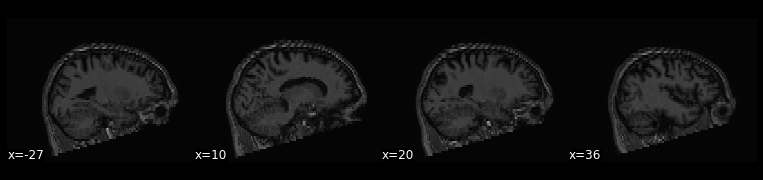

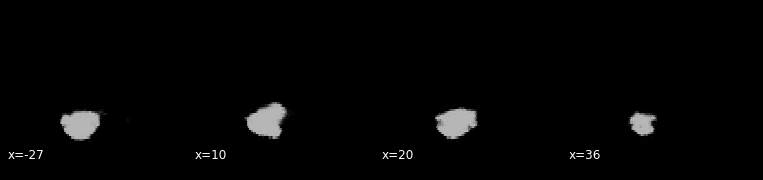

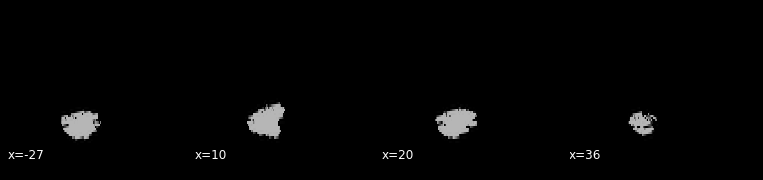

In [10]:
nifti_cerebellum_mask = nib.Nifti1Image(true_, affine)
plot_anat(bg, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10, 20])
plot_anat(nifti_img, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10, 20])
plot_anat(nifti_cerebellum_mask, draw_cross=False, display_mode='x', cut_coords=[36, -27, 10, 20])



C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


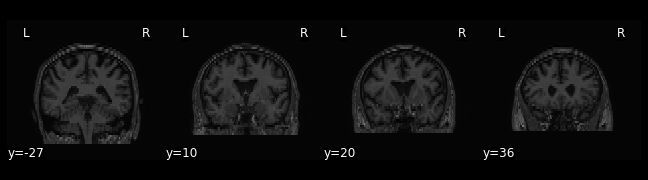

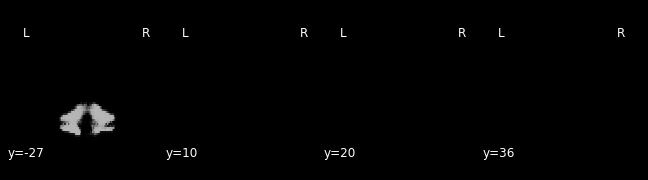

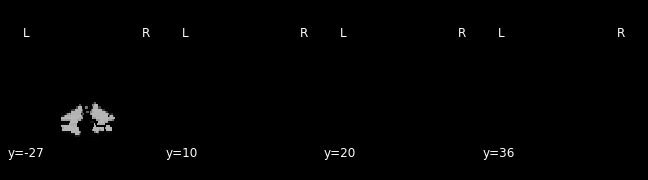

In [11]:
plot_anat(bg, draw_cross=False, display_mode='y', cut_coords=[36, -27, 10, 20])
plot_anat(nifti_img, draw_cross=False, display_mode='y', cut_coords=[36, -27, 10, 20])
plot_anat(nifti_cerebellum_mask, draw_cross=False, display_mode='y', cut_coords=[36, -27, 10, 20])

C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\plotting\displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\image\resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\plotting\displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

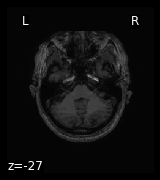

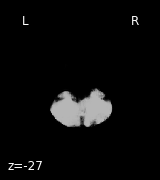

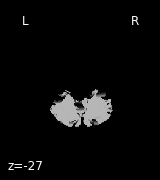

In [14]:

plot_anat(bg, draw_cross=False, display_mode='z', cut_coords=[-27])
plot_anat(nifti_img, draw_cross=False, display_mode='z', cut_coords=[-27])
plot_anat(nifti_cerebellum_mask, draw_cross=False, display_mode='z', cut_coords=[-27])

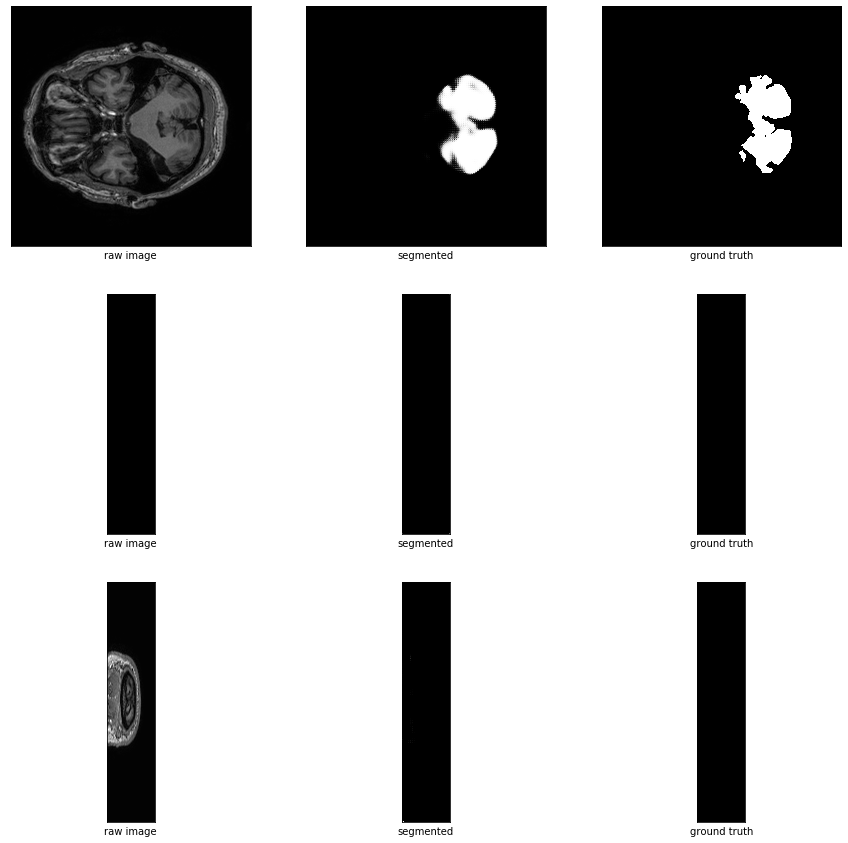

In [37]:
imgs_to_show = [
    bg.get_fdata()[:,:,10],
    nifti_img.get_fdata()[:,:,10],
    nifti_cerebellum_mask.get_fdata()[:,:,10],
    bg.get_fdata()[10,:,:],
    nifti_img.get_fdata()[10,:,:],
    nifti_cerebellum_mask.get_fdata()[10,:,:],
    bg.get_fdata()[:,200,:],
    nifti_img.get_fdata()[:,200,:],
    nifti_cerebellum_mask.get_fdata()[:,200,:],
]
labls = ['raw image', 'segmented', 'ground truth']


fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(len(imgs_to_show)):
    plt.subplot(columns, rows, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs_to_show[i], cmap='gray', resample=False)
    plt.xlabel(labls[i%3])

plt.show()

#plt.imshow(nifti_cerebellum_mask.get_fdata()[:,:,10], cmap='binary', aspect='equal', resample=False)